# Data Processing

In [10]:
from pathlib import Path
import pandas as pd


DATA_PATH = Path('../data')
artists_df = pd.read_csv(DATA_PATH/'artists.csv', index_col=0)

In [14]:
artists_df

,continent,genre,is_famous,number_of_streams,week_no_created
artist_id,,,,,
0,Oceana,Jazz,True,46678,0
1,Europe,Electronic,False,8543,0
2,North America,Jazz,True,24151,1
3,North America,Jazz,True,41359,1
4,South America,Jazz,False,4937,2
...,...,...,...,...,...
993,Europe,Jazz,False,0,99
994,South America,Pop,False,2,99
995,North America,Alternative,False,0,99


In [13]:
songs_df = pd.read_csv(DATA_PATH/'songs.csv', index_col=0)
songs_df

,artist_id,genre,is_artist_famous,is_premium,is_famous,week_released,number_of_streams
song_id,,,,,,,
0,2,Jazz,False,False,True,1,3373
1,3,Jazz,False,True,True,2,18968
2,7,Jazz,False,False,True,4,1626
3,5,Pop,False,False,True,5,1529
4,6,Alternative,False,False,True,5,1441
...,...,...,...,...,...,...,...
8177,979,Alternative,False,False,False,99,3
8178,983,Rock,False,False,False,99,3
8179,986,Pop,True,True,True,99,73


In [15]:
streams_df = pd.read_csv(DATA_PATH/'streams.csv', index_col=0)
streams_df

,user_id,song_id,week_no
steam_id,,,
0,19,0,1
1,21,0,1
2,26,0,1
3,26,0,1
4,27,0,1
...,...,...,...
2434279,9998,7834,99
2434280,9998,4241,99
2434281,9998,7671,99


In [16]:
users_df = pd.read_csv(DATA_PATH/'users.csv', index_col=0)
users_df

,user_name,age,continent,is_subscribed,week
user_id,,,,,
0,Dr. Charles Ortiz PhD,30,Africa,False,0
1,Mark Scott,26,North America,True,0
2,Jeffrey Cohen,27,Asia,False,0
3,Robert Gutierrez,34,South America,False,0
4,Justin Walker,29,North America,False,0
...,...,...,...,...,...
9994,James Savage,44,Africa,False,99
9995,Bradley Cook,26,North America,False,99
9996,Katherine Skinner,19,Europe,False,99


In [20]:
streams_df.week_no.max()

99

In [179]:
from tqdm import tqdm


MINIMAL_HISTORY_WEEKS = 15
PREDICT_IN_FUTURE_WEEKS = 20
MAX_HISTORY_WEEK = 99

results = []

small_sample_songs_df = songs_df
# .loc[:1000]

for song_id, song in tqdm(small_sample_songs_df.iterrows(), total=small_sample_songs_df.shape[0]):
    for week_no in range(song.week_released + MINIMAL_HISTORY_WEEKS, MAX_HISTORY_WEEK-PREDICT_IN_FUTURE_WEEKS+1):
        # print(week_released)
        sel_artist_df = artists_df.loc[song.artist_id]
        sel_streams_df = streams_df[
            (streams_df.song_id==song_id) &
            (streams_df.week_no<week_no) & 
            (streams_df.week_no>=week_no-MINIMAL_HISTORY_WEEKS) 
        ]
        sel_users_df = users_df.loc[sel_streams_df.user_id.unique()]
        
        perc_listeners_from_continent_dict = (pd.get_dummies(sel_users_df.continent, prefix='perc_listeners_from').sum()/sel_users_df.shape[0]).to_dict()
        sel_target_streams_df = streams_df[
            (streams_df.song_id==song_id) &
            (streams_df.week_no==week_no+PREDICT_IN_FUTURE_WEEKS)
        ]
        
        row = {
            "genre": song.genre,
            "is_premium": song.is_premium,
            "artist_continent": sel_artist_df.continent,
            "weeks_after_artist_created": week_no - sel_artist_df.week_no_created,
            "weeks_after_song_released": week_no - song.week_released,
            "unique_listeners": sel_streams_df.user_id.nunique(),
            "total_streams": sel_streams_df.shape[0],
            "perc_of_subscribed_listeners": sel_users_df.is_subscribed.mean(),
            "average_listener_age": sel_users_df.age.mean(),
            **perc_listeners_from_continent_dict,
            'target': sel_target_streams_df.shape[0],
        }
        results.append(row)
        
df = pd.DataFrame(results)

 10%|██████████████████▌                                                                                                                                                                         | 99/1001 [01:10<10:44,  1.40it/s]


KeyboardInterrupt: 

In [180]:
df = pd.DataFrame(results)

In [181]:
df = df.join(pd.get_dummies(df.genre, prefix='song_genre').fillna(0))
df = df.join(pd.get_dummies(df.artist_continent, prefix='artist_continent').fillna(0))
df = df.drop(columns=['genre', 'artist_continent'], errors='ignore')
df.is_premium = df.is_premium.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5183 entries, 0 to 5182
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   is_premium                         5183 non-null   int64  
 1   weeks_after_artist_created         5183 non-null   int64  
 2   weeks_after_song_released          5183 non-null   int64  
 3   unique_listeners                   5183 non-null   int64  
 4   total_streams                      5183 non-null   int64  
 5   perc_of_subscribed_listeners       5183 non-null   float64
 6   average_listener_age               5183 non-null   float64
 7   perc_listeners_from_Africa         5160 non-null   float64
 8   perc_listeners_from_Asia           5182 non-null   float64
 9   perc_listeners_from_Europe         5183 non-null   float64
 10  perc_listeners_from_North America  5183 non-null   float64
 11  perc_listeners_from_Oceana         4905 non-null   float

In [182]:
df.loc[:, df.columns.str.startswith('perc_listeners_from')] = df.loc[:, df.columns.str.startswith('perc_listeners_from')].fillna(0)

In [183]:
df.to_csv(DATA_PATH/'train_data.csv')

# Train Test Split

In [184]:
df = pd.read_csv(DATA_PATH/'train_data.csv', index_col=0)

In [185]:
y = df.pop('target')
X = df.copy()

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

# Standarization

In [187]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# ML Model Architecture

In [194]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Training and Testing ML Model

In [195]:
model.fit(X_train, y_train)

LinearRegression()

In [196]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = model.predict(X_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate Root Mean Squared Error (RMSE) on train and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R-squared (R2) on train and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"RMSE on train set: {rmse_train:.2f}")
print(f"RMSE on test set: {rmse_test:.2f}")

print(f"R-squared on train set: {r2_train:.2f}")
print(f"R-squared on test set: {r2_test:.2f}")



RMSE on train set: 7.95
RMSE on test set: 7.51
R-squared on train set: 0.98
R-squared on test set: 0.98


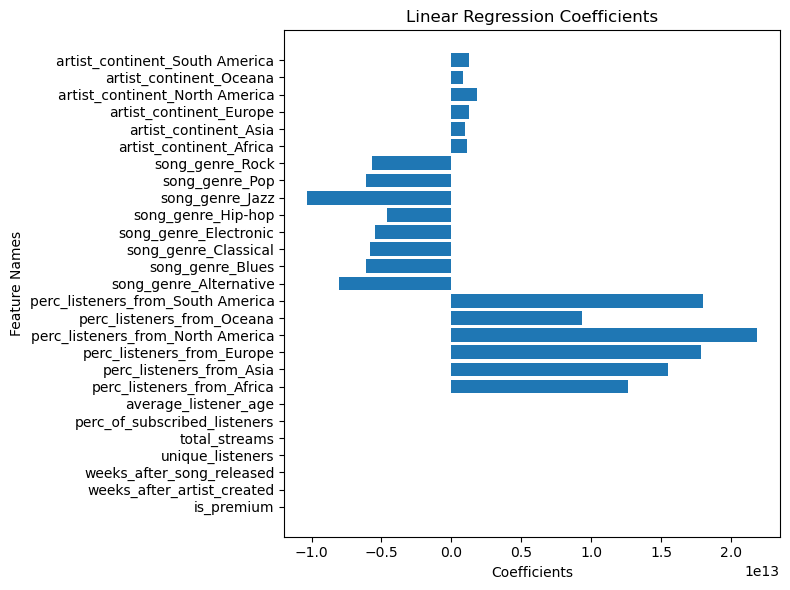

In [197]:
import matplotlib.pyplot as plt


# Get the coefficients and corresponding feature names
coefficients = model.coef_
feature_names = X.columns

# Create a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(feature_names, coefficients)

# Add labels and title
plt.xlabel('Coefficients')
plt.ylabel('Feature Names')
plt.title('Linear Regression Coefficients')

# Show the plot
plt.tight_layout()
plt.show()